In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!mv "archive.zip" archive.zip
!unzip archive.zip -d /content/dataset/

mv: 'archive.zip' and 'archive.zip' are the same file
Archive:  archive.zip
  inflating: /content/dataset/State-wise_OLX/AN/AN1.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN1.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN10.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN10.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN2.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN2.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN4.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN4.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN5.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN5.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN6.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN6.xml  
  inflating: /content/dataset/State-wise_OLX/AN/AN7.jpg  
  inflating: /content/dataset/State-wise_OLX/AN/AN7.xml  
  inflating: /content/dataset/State-wise_OLX/AP/AP1.jpg  
  inflating: /content/dataset/State-wise_OLX/AP/AP1.

In [ ]:
import os
import shutil

parent_folder = "dataset"

source_folders = [
    os.path.join(parent_folder, "google_images"),
    os.path.join(parent_folder, "state-wise_OLX"),
    os.path.join(parent_folder, "video_images"),
]

destination = "all_data"

os.makedirs(destination, exist_ok=True)

for folder in source_folders:
    if os.path.exists(folder):
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith((".jpg", ".png", ".xml")):
                    shutil.move(os.path.join(root, file), os.path.join(destination, file))

print("✅ All images and XML files moved to 'all_data/' successfully!")


✅ All images and XML files moved to 'all_data/' successfully!


In [ ]:
import os
import shutil
import random

data_dir = "all_data"
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

images = [f for f in os.listdir(data_dir) if f.endswith((".jpg", ".png"))]

random.shuffle(images)

train_split = int(0.7 * len(images))
val_split = int(0.8 * len(images))

train_files = images[:train_split]
val_files = images[train_split:val_split]
test_files = images[val_split:]

def move_files(file_list, destination):
    for file in file_list:
        xml_file = file.replace(".jpg", ".xml").replace(".png", ".xml")
        shutil.move(os.path.join(data_dir, file), os.path.join(destination, file))
        if os.path.exists(os.path.join(data_dir, xml_file)):  # Move XML if exists
            shutil.move(os.path.join(data_dir, xml_file), os.path.join(destination, xml_file))

move_files(train_files, train_dir)
move_files(val_files, val_dir)
move_files(test_files, test_dir)

print(f"✅ Data split completed:\nTrain: {len(train_files)}\nVal: {len(val_files)}\nTest: {len(test_files)}")


✅ Data split completed:
Train: 552
Val: 79
Test: 158


In [ ]:
import os
import shutil
dataset_path = "dataset"
sets = ["train", "test", "val"]
for s in sets:
    os.makedirs(os.path.join(dataset_path, s, "images"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, s, "labels"), exist_ok=True)
    for file in os.listdir(os.path.join(dataset_path, s)):
        if file.endswith((".jpg", ".png")):
            shutil.move(os.path.join(dataset_path, s, file), os.path.join(dataset_path, s, "images", file))
        elif file.endswith(".xml"):
            shutil.move(os.path.join(dataset_path, s, file), os.path.join(dataset_path, s, "labels", file))

print("✅ Dataset organized into 'images' and 'labels' folders!")

✅ Dataset organized into 'images' and 'labels' folders!


In [ ]:
import os
import xml.etree.ElementTree as ET
dataset_path = "dataset"
sets = ["train", "test", "val"]
classes = {}
class_id_counter = 0

for s in sets:
    xml_dir = os.path.join(dataset_path, s, "labels")
    yolo_dir = os.path.join(dataset_path, s, "labels_yolo")
    os.makedirs(yolo_dir, exist_ok=True)

    for xml_file in os.listdir(xml_dir):
        if xml_file.endswith(".xml"):
            xml_path = os.path.join(xml_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            img_width = int(root.find("size/width").text)
            img_height = int(root.find("size/height").text)

            yolo_txt_path = os.path.join(yolo_dir, xml_file.replace(".xml", ".txt"))

            with open(yolo_txt_path, "w") as yolo_file:
                for obj in root.findall("object"):
                    name = obj.find("name").text.strip()
                    if name not in classes:
                        classes[name] = class_id_counter
                        print(f"New Class Found: {name} (ID: {class_id_counter})")
                        class_id_counter += 1

                    class_id = classes[name]
                    xmin = int(obj.find("bndbox/xmin").text)
                    ymin = int(obj.find("bndbox/ymin").text)
                    xmax = int(obj.find("bndbox/xmax").text)
                    ymax = int(obj.find("bndbox/ymax").text)

                    x_center = (xmin + xmax) / (2 * img_width)
                    y_center = (ymin + ymax) / (2 * img_height)
                    width = (xmax - xmin) / img_width
                    height = (ymax - ymin) / img_height

                    yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

classes_txt_path = os.path.join(dataset_path, "classes.txt")
with open(classes_txt_path, "w") as f:
    for name, class_id in sorted(classes.items(), key=lambda x: x[1]):
        f.write(f"{name}\n")

print("\n✅ XML to YOLO conversion complete! Labels saved in 'labels_yolo/'")
print(f"📂 Classes saved in '{classes_txt_path}'")
print(f"🔍 Total Classes Found: {len(classes)}")


New Class Found: MH01DE2780 (ID: 0)
New Class Found: MH47Y1124 (ID: 1)
New Class Found: MH02BT6482 (ID: 2)
New Class Found: MH01AL9693 (ID: 3)
New Class Found: MH02MA5324 (ID: 4)
New Class Found: MH01CT9150 (ID: 5)
New Class Found: MH47Y0205 (ID: 6)
New Class Found: MH43BP8173 (ID: 7)
New Class Found: MH02DN8718 (ID: 8)
New Class Found: MH02DS9365 (ID: 9)
New Class Found: KL10AV6342 (ID: 10)
New Class Found: MH02ER9194 (ID: 11)
New Class Found: TERRANO (ID: 12)
New Class Found: MH02EE8407 (ID: 13)
New Class Found: MH02BQ9628 (ID: 14)
New Class Found: MH02EU4077 (ID: 15)
New Class Found: MH14FS5229 (ID: 16)
New Class Found: GJ03JL0126 (ID: 17)
New Class Found: MH01AX3070 (ID: 18)
New Class Found: MH02BR4503 (ID: 19)
New Class Found: MH02AQ2299 (ID: 20)
New Class Found: MH01DB1477 (ID: 21)
New Class Found: MH03CS6266 (ID: 22)
New Class Found: MH02DZ9898 (ID: 23)
New Class Found: MH03DV2010 (ID: 24)
New Class Found: MH01AU0059 (ID: 25)
New Class Found: DL8CN6308 (ID: 26)
New Class Found: 

In [ ]:
import os

# Path to your YOLO labels folder
labels_path = "dataset/test/labels"
for filename in os.listdir(labels_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(labels_path, filename)
        with open(file_path, "r") as file:
            lines = file.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                parts[0] = "0"
                new_lines.append(" ".join(parts))
        with open(file_path, "w") as file:
            file.write("\n".join(new_lines))

print("All class IDs changed to 0 successfully!")

All class IDs changed to 0 successfully!


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")# load and try for yolov8m,yolov8n also
print("YOLO is working!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 107MB/s] 

YOLO is working!


In [ ]:
import os

label_path = "/content/dataset/val/labels"  # do for train,val

for file_name in os.listdir(label_path):
    file_path = os.path.join(label_path, file_name)


    if os.path.isdir(file_path):
        continue

    with open(file_path, "r") as f:
        lines = f.readlines()

    fixed_lines = []
    for line in lines:
        parts = line.strip().split()
        parts[0] = "0"
        fixed_lines.append(" ".join(parts))

    with open(file_path, "w") as f:
        f.write("\n".join(fixed_lines))

print("✅ Labels fixed! All class IDs are now 0.")


✅ Labels fixed! All class IDs are now 0.


In [ ]:
import os
from PIL import Image

image_path = "/content/dataset/test/images" # do for train,test

for file_name in os.listdir(image_path):
    file_path = os.path.join(image_path, file_name)
    try:
        img = Image.open(file_path)
        img.verify()
    except Exception as e:
        print(f"❌ Corrupt image detected: {file_name}")
        os.remove(file_path)
        print(f"🗑️ Deleted {file_name}")

print("✅ Corrupt image cleanup complete!")


✅ Corrupt image cleanup complete!


In [ ]:
model.train(
    data="dataset/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=32,
    augment=True,
    patience=15
)

Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset/dataset.yaml, epochs=50, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

train: Scanning /content/dataset/train/labels... 552 images, 0 backgrounds, 0 corrupt: 100%|██████████| 552/552 [00:00<00:00, 1974.15it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 883.48it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.92G      4.211      7.586      2.969         15        640: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         79         79          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.15G      3.524      3.701      2.377         18        640: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

                   all         79         79     0.0519     0.0759    0.00937    0.00181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.43G      2.486      2.175      1.834         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         79         79     0.0597      0.291     0.0613     0.0188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.43G       1.81      1.496      1.508         14        640: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         79         79       0.54      0.658      0.613      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.43G      1.593       1.28      1.396         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         79         79       0.72      0.557      0.639      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.43G      1.529      1.165      1.315         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         79         79      0.587      0.759      0.709       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.43G      1.433      1.054      1.267         12        640: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         79         79      0.705      0.278      0.374      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.43G      1.356     0.9845      1.247         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         79         79      0.783      0.776      0.836      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.43G      1.225     0.9272      1.184         17        640: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         79         79      0.825      0.848      0.882      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.43G      1.206     0.8421      1.179         18        640: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         79         79      0.929      0.671      0.761      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.43G      1.141     0.8077      1.148         11        640: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         79         79      0.922      0.658      0.814      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.43G      1.103     0.7594      1.097         20        640: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         79         79       0.88      0.646      0.779      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.43G      1.046     0.7031      1.083         17        640: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         79         79      0.971      0.858      0.959      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.43G     0.9698     0.6954      1.034         16        640: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         79         79      0.822      0.877      0.934      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.43G     0.9751     0.6467      1.048         10        640: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         79         79      0.832      0.924      0.952      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.43G     0.9591     0.6461       1.07         18        640: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         79         79      0.958      0.871      0.967      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.43G      0.903     0.6307      1.026         18        640: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         79         79      0.931      0.949      0.979      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.43G     0.9177     0.6166      1.023         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         79         79      0.936      0.911      0.949      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.43G      0.846     0.5774     0.9853         18        640: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         79         79       0.92      0.937      0.973      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.43G     0.8815     0.5848     0.9951         17        640: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         79         79       0.98      0.937      0.984      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.43G     0.8272     0.5458     0.9723         16        640: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         79         79      0.934      0.924      0.973      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.43G     0.8746     0.5593      1.001         12        640: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         79         79      0.944      0.937      0.978      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.43G      0.877     0.5497     0.9795         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         79         79      0.974      0.937      0.973      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.43G     0.8187     0.5225     0.9749         13        640: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         79         79      0.958      0.949      0.983      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.43G     0.7906     0.5074     0.9659         12        640: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         79         79      0.911      0.987      0.974      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.43G     0.7957     0.5179     0.9632         14        640: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         79         79      0.983      0.937      0.981      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.43G     0.7833     0.5061     0.9779         10        640: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         79         79      0.928      0.986      0.989      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.43G     0.7605     0.5015     0.9391         22        640: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         79         79       0.97      0.962      0.984      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.43G     0.7601     0.4853     0.9484         12        640: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         79         79       0.97      0.962       0.98      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.43G      0.733     0.4649     0.9341         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         79         79      0.972      0.975      0.979      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.43G     0.7312     0.4664      0.933         18        640: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         79         79      0.962      0.964      0.974      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.43G     0.7516     0.4721     0.9317         13        640: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         79         79      0.948      0.975      0.987      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.43G     0.7212     0.4567     0.9301         13        640: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         79         79      0.951      0.974      0.988      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.43G     0.6915     0.4402     0.9276         14        640: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         79         79      0.965      0.949      0.987      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.43G      0.673     0.4369     0.9193         13        640: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         79         79      0.962      0.974      0.977      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.43G     0.6975     0.4267     0.9342         16        640: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         79         79      0.975      0.975       0.99      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.43G     0.6835      0.435     0.9275         18        640: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         79         79      0.975      0.975      0.993      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.43G       0.67     0.4293      0.927         14        640: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         79         79      0.963      0.985      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.43G     0.6479     0.4184     0.8989         13        640: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         79         79      0.975      0.973      0.983      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.43G     0.6418     0.4142     0.9174         15        640: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         79         79      0.975      0.983      0.978      0.829


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.43G     0.6186     0.4021     0.8968          8        640: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         79         79      0.963          1       0.99      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.43G     0.6192      0.376     0.8994          8        640: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         79         79      0.973      0.975       0.99      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.43G     0.6126     0.3672     0.9056          8        640: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         79         79      0.973      0.975      0.989      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.43G     0.5751     0.3582     0.8765          8        640: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         79         79      0.975      0.974      0.987      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.43G     0.5662     0.3451     0.8724          8        640: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         79         79      0.975      0.984      0.989       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.43G      0.587     0.3531      0.885          7        640: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         79         79      0.963      0.985       0.99      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.43G     0.5507     0.3611     0.8693          8        640: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         79         79      0.975      0.987      0.991      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.43G     0.5324     0.3265     0.8662          8        640: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         79         79      0.975      0.987      0.991       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.43G     0.5366      0.326     0.8737          8        640: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         79         79      0.972      0.975      0.989      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.43G     0.5239     0.3237     0.8596          7        640: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         79         79      0.975      0.986      0.988      0.861



50 epochs completed in 0.183 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


                   all         79         79      0.971      0.975       0.99      0.868
Speed: 0.3ms preprocess, 16.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b8d82440650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 


0: 416x640 1 number_plate, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


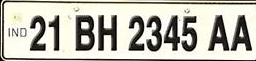

In [ ]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train5/weights/best.pt")  # Update with your model path

# Load the test image
image_path = "/content/test_image.jpg"
image = cv2.imread(image_path)

# Perform inference
results = model(image)

# Extract bounding box coordinates
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Get bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)  # Convert to integers

        # Crop the detected number plate
        cropped_plate = image[y1:y2, x1:x2]

        # Save and display the cropped image
        cv2.imwrite("cropped_plate.jpg", cropped_plate)
        cv2_imshow(cropped_plate)  # Display in Google Colab

# Now, you can proceed with OCR on 'cropped_plate.jpg'
